In [1]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt



def molecular_energies(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )[0]

    # Obtain the matrix representation of the Hamiltonian
    ee = qml.eigvals(hamiltonian)
    return np.sort(ee)

## Uso de memoria

In [2]:
from pympler import asizeof

def molecular_memoria(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )

    return [asizeof.asizeof(hamiltonian), qubits]

In [4]:
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.5])
symbols = [["H", "H"], ["He", "He"], ["Li", "Li"], ["Be", "Be"], ["B", "B"], ["C", "C"], ["N", "N"]]

for i in symbols:
    print(molecular_memoria(i, coordinates, "sto-3g"))

[43296, 4]
[43016, 4]
[30372976, 20]
[22640184, 20]
[30322624, 20]
[42388192, 20]
[30917104, 20]


In [8]:
for i in symbols:
    params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf'
    }

    system = vqe_molecular(i, coordinates, params)
    system.set_group_characteristics()
    print( asizeof.asizeof(system) )

4864
4856
9149400
8948664
9194808
9434560
9195688


## Li-H

In [40]:
def space(x):
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0, x], requires_grad=True)

symbols = ["Li", "H"]
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
    'active_electrons': 2,
    'active_orbitals': 5,
}

distance = [1.484644426, 2.96928852, 5.938577704]
#molecule1 = vqe_molecular(symbols, coordinates, params)
#molecule1.set_group_characteristics()

In [4]:
valores = []

for d in distance:
    
    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()
    aux = []

    print("kupccgsd")
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": system.qubits
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    aux.append(energy1)

    print("uccsd")
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": system.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    aux.append(energy1)


    valores.append(aux)

kupccgsd
+1
+1
+1
+1
+1
+1
uccsd
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
kupccgsd
+1
+1
+1
+1
+1
+1
+1
uccsd
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
kupccgsd
+1
+1
+1
+1
+1
+1
+1
+1
+1
uccsd
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


In [41]:
ee_final = []
for d in distance:
    ee = molecular_energies(symbols=symbols, coordinates=space(d), basis_set=params["basis"])
    ee_final.append(ee[0])

/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [38]:
import pandas as pd

aux1 =  [pd.read_csv("lih_undereq_kup.csv")["0"].values, pd.read_csv("lih_undereq_uc.csv")["0"].values]
aux2 =  [pd.read_csv("lih_eq_kup.csv")["0"].values, pd.read_csv("lih_eq_uc.csv")["0"].values]
aux3 =  [pd.read_csv("lih_geq_kup.csv")["0"].values, pd.read_csv("lih_geq_uc.csv")["0"].values]

valores = [aux1, aux2, aux3]

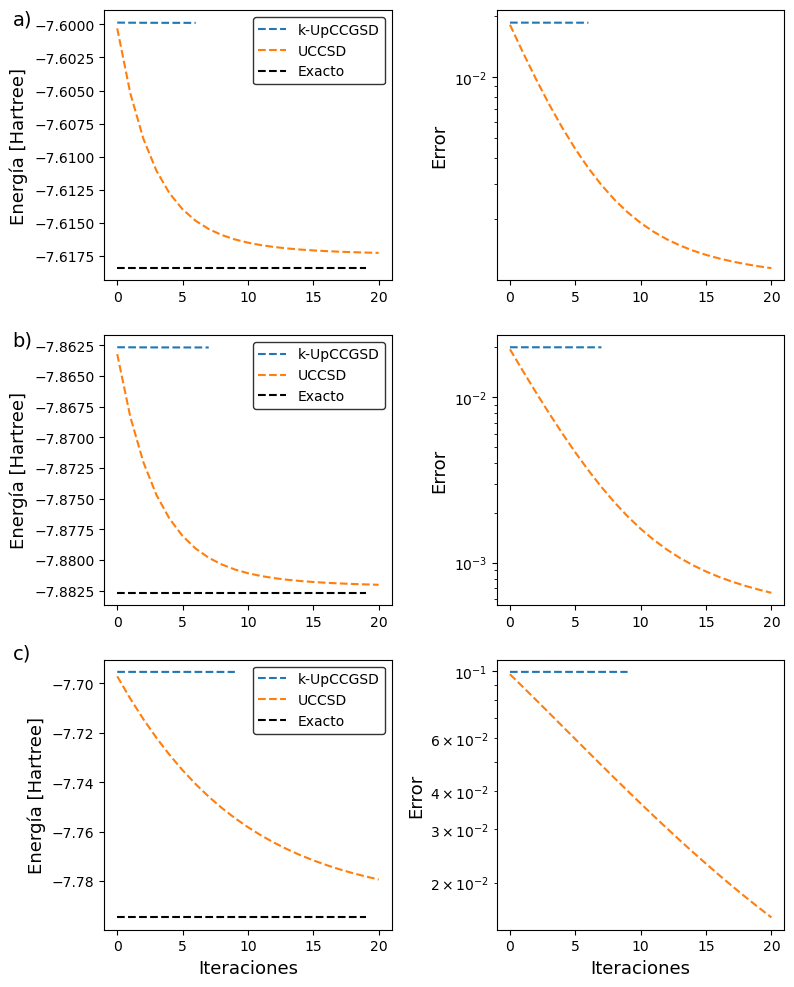

In [45]:
fig, ax = plt.subplots(3, 2, figsize=(8,10),)
ax[2][0].set_xlabel("Iteraciones", fontsize=13)
ax[2][1].set_xlabel("Iteraciones", fontsize=13)

ax[0][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[0][1].set_ylabel("Error", fontsize=13)
ax[1][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[1][1].set_ylabel("Error", fontsize=13)
ax[2][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[2][1].set_ylabel("Error", fontsize=13)
aux = 20

for i in range(3):
    ax[i][0].plot([j for j in range(len(valores[i][0]))], valores[i][0], ls="dashed", label="k-UpCCGSD")
    ax[i][0].plot([j for j in range(len(valores[i][1]))], valores[i][1], ls="dashed", label="UCCSD")
    ax[i][0].plot([j for j in range( aux ) ], [ee_final[i] for j in range(aux)], color="black", ls="dashed", label="Exacto")

    ax[i][1].plot([j for j in range(len(valores[i][0]))], [np.abs(valores[i][0][j] -ee_final[i]) for j in range(len(valores[i][0]))], 
        ls="dashed", label="kUpCCGSD")
    ax[i][1].plot([j for j in range(len(valores[i][1]))], [np.abs(valores[i][1][j] -ee_final[i]) for j in range(len(valores[i][1]))], 
        ls="dashed", label="UCCSD")
    ax[i][1].set_yscale("log")

    ax[i][0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)

ax[0][0].text(-8, -7.6, 'a)', fontsize=14, color='black')
ax[1][0].text(-8, -7.8625, 'b)', fontsize=14, color='black')
ax[2][0].text(-8, -7.69, 'c)', fontsize=14, color='black')
fig.tight_layout()
plt.show()

### Grafica del potencial

In [21]:
potencial_k = []

for d in np.linspace(1, 5, 20):
    print(d)

    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": system.qubits
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_k.append(energy1[-1])


1.0
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4210526315789473
+1
+1
+1
+1
+1
+1
1.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.8421052631578947
+1
+1
+1
+1
+1
+1
+1
2.052631578947368
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.263157894736842
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.473684210526316
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.894736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3157894736842106
+1
+1
+1
+1
+1
+1
+1
+1
3.526315789473684
+1
+1
+1
+1
+1
+1
+1
+1
3.7368421052631575
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.9473684210526314
+1
+1
+1
+1
+1
+1
+1
4.157894736842105
+1
+1
+1
+1
+1
+1
+1
+1
+1
4.368421052631579
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
4.578947368421052
+1
+1
+1
+1
+1
+1
+1
+1
4.789473684210526
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
5.0
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


In [24]:
potencial_uc = []

for d in np.linspace(1, 5, 20):
    print(d)
    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": system.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_uc.append(energy1[-1])

1.0
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4210526315789473
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.8421052631578947
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.052631578947368
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.263157894736842
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.473684210526316
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.894736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3157894736842106
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.526315789473684
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


In [46]:
ee_final = []
for d in np.linspace(1, 5, 20):
    print( d )
    ee = molecular_energies(symbols=symbols, coordinates=space(d), basis_set=params["basis"])
    ee_final.append(ee[0])

1.0


/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


1.2105263157894737
1.4210526315789473
1.631578947368421
1.8421052631578947
2.052631578947368
2.263157894736842
2.473684210526316
2.6842105263157894
2.894736842105263
3.1052631578947367
3.3157894736842106
3.526315789473684
3.7368421052631575
3.9473684210526314
4.157894736842105
4.368421052631579
4.578947368421052
4.789473684210526
5.0


In [47]:
potencial_k = pd.read_csv("lih_potencial_kup.csv")["0"].values
potencial_uc = pd.read_csv("lih_potencial_uc.csv")["0"].values


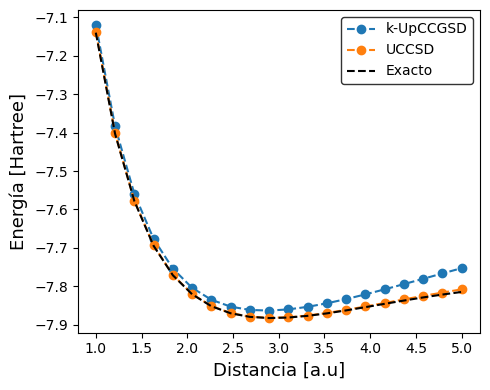

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5,4),)
ax.set_xlabel("Distancia [a.u]", fontsize=13)
ax.set_ylabel("Energía [Hartree]", fontsize=13)

ax.plot(np.linspace(1, 5, 20), potencial_k, marker='o', ls="dashed", label="k-UpCCGSD")
ax.plot(np.linspace(1, 5, 20), potencial_uc, marker='o', ls="dashed", label="UCCSD")
ax.plot(np.linspace(1, 5, 20), ee_final, color="black", ls="dashed", label="Exacto")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

## Trimero

In [2]:
def space(x):
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0, x, 0.0, x/2, np.sqrt(x*x - (x*x)/4)], requires_grad=True)

symbols = ["H", "H", "H"]
params = {
    'mapping': "jordan_wigner",
    'charge': 1, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

distance = [0.850376694, 1.700753389, 3.401506778]

In [4]:
system = vqe_molecular(symbols, space(distance[1]), params)
system.set_group_characteristics()

In [5]:
system.hamiltonian_object

[['IIIIII', 'IZIIII', 'IZZIII', 'IIZIII', 'YZZXXY'],
 ['YZZYXX'],
 ['XZZXYY'],
 ['XZZYYX'],
 ['YXXYII', 'IXXIXX'],
 ['IYXIXY', 'YYXXII'],
 ['IXYIYX', 'XXYYII'],
 ['XYYXII', 'IYYIYY'],
 ['YXIIXY', 'YIYIII', 'IXIXII', 'IIYXXY'],
 ['YYIIXX', 'IIYYXX', 'IYIYII'],
 ['IIXXYY', 'XXIIYY', 'XIXIII'],
 ['XYIIYX', 'IIXYYX'],
 ['IIIZIZ',
  'IIIIZZ',
  'YZYIII',
  'IIIZII',
  'YZYZII',
  'IIIIZI',
  'YZYIZI',
  'IIIIIZ',
  'YZYIIZ',
  'IZIZII',
  'IZIIZI',
  'IZIIIZ',
  'IIIZZI'],
 ['XZXZII', 'XZXIII', 'XZXIZI', 'XZXIIZ'],
 ['ZIIIII',
  'ZZIIII',
  'ZIIIIZ',
  'IIZZII',
  'ZIZIII',
  'ZIIZII',
  'IIZIZI',
  'IIZIIZ',
  'ZIIIZI'],
 ['IYZYII', 'ZYZYII', 'IYZYZI', 'IYZYIZ'],
 ['IXZXZI', 'IXZXIZ', 'IXZXII', 'ZXZXII']]

In [3]:
valores_hydrogen = []

for d in distance:
    print(d)
    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()
    aux = []

    print("kupccgsd")
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": system.qubits
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    aux.append(energy1)

    print("uccsd")
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": system.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    aux.append(energy1)


    valores_hydrogen.append(aux)

0.850376694
kupccgsd
0.4756953693924743
0.47417788018315976
0.47370163756713146
0.4735408992460129
0.47348633080125013
0.4734677482000558
0.4734613834713253
0.4734591787024189
uccsd
0.47341109673796156
0.46899425051371496
0.46764565924861756
0.46709295484020774
0.4668128873676573
0.466654600467694
0.46656058588953453
0.466503419447735
0.46646822402778565
0.46644639262621357
0.46643278138891225
0.4664242612774468
0.4664189089086195
0.466415534234354
0.46641339774263224
0.4664120384860337
1.700753389
kupccgsd
-1.2439959277186057
-1.2481841439386543
-1.2505326872710376
-1.2518450047595642
-1.2525764827944583
-1.2529836258246716
-1.2532100646260358
-1.2533359477846502
-1.2534059132904087
-1.253444795281171
-1.2534664019952488
-1.253478408611674
-1.2534850805789288
-1.2534887881965036
-1.2534908485825664
-1.253491993619396
uccsd
-1.243495846940524
-1.2517401601804985
-1.2561377358571397


KeyboardInterrupt: 

In [6]:
ee_final = []
for d in distance:
    ee = molecular_energies(symbols=symbols, coordinates=space(d), basis_set=params["basis"], charge=1)
    ee_final.append(ee[0])

/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


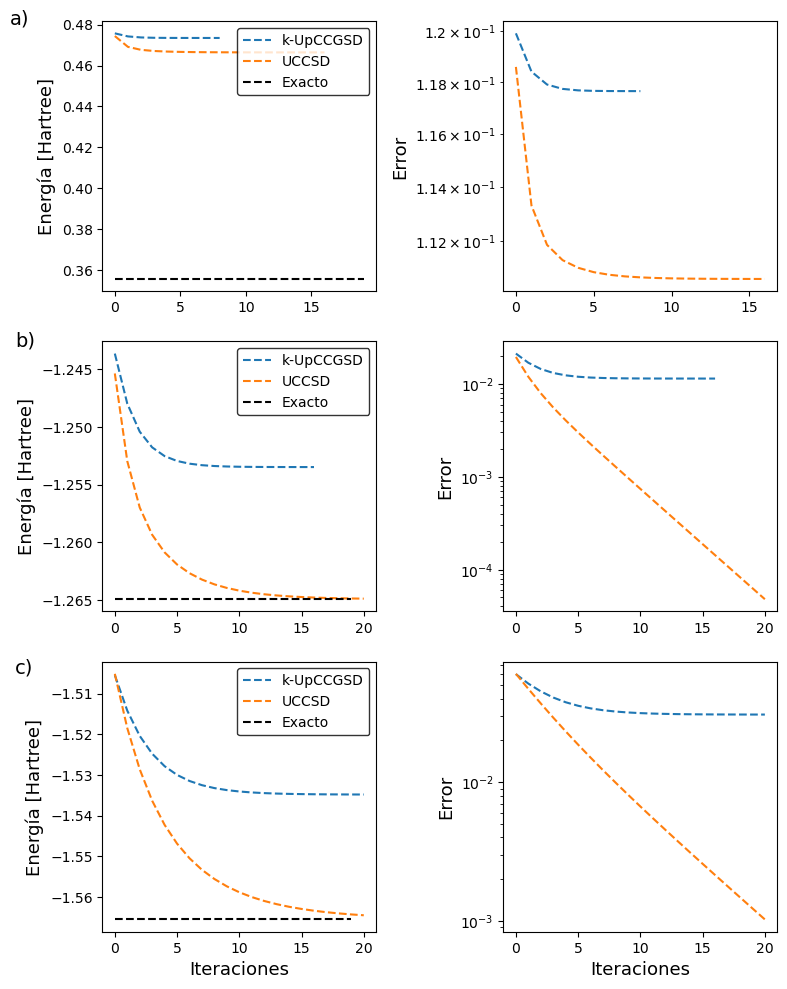

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(8,10),)
ax[2][0].set_xlabel("Iteraciones", fontsize=13)
ax[2][1].set_xlabel("Iteraciones", fontsize=13)

ax[0][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[0][1].set_ylabel("Error", fontsize=13)
ax[1][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[1][1].set_ylabel("Error", fontsize=13)
ax[2][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[2][1].set_ylabel("Error", fontsize=13)
aux = 20

for i in range(3):
    ax[i][0].plot([j for j in range(len(valores_hydrogen[i][0]))], valores_hydrogen[i][0], ls="dashed", label="k-UpCCGSD", marker='o')
    ax[i][0].plot([j for j in range(len(valores_hydrogen[i][1]))], valores_hydrogen[i][1], ls="dashed", label="UCCSD", marker='o')
    ax[i][0].plot([j for j in range( aux ) ], [ee_final[i] for j in range(aux)], color="black", ls="dashed", label="Exacto", marker='o')

    ax[i][1].plot([j for j in range(len(valores_hydrogen[i][0]))], [np.abs(valores_hydrogen[i][0][j] -ee_final[i]) for j in range(len(valores_hydrogen[i][0]))], 
        ls="dashed", label="kUpCCGSD")
    ax[i][1].plot([j for j in range(len(valores_hydrogen[i][1]))], [np.abs(valores_hydrogen[i][1][j] -ee_final[i]) for j in range(len(valores_hydrogen[i][1]))], 
        ls="dashed", label="UCCSD")
    ax[i][1].set_yscale("log")

    ax[i][0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)

ax[0][0].text(-8, 0.48, 'a)', fontsize=14, color='black')
ax[1][0].text(-8, -1.243, 'b)', fontsize=14, color='black')
ax[2][0].text(-8, -1.505, 'c)', fontsize=14, color='black')
fig.tight_layout()
plt.show()

In [26]:
potencial_k_hydrogen = []

for d in np.linspace(0.5, 5, 20):
    print(d)

    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": system.qubits
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_k_hydrogen.append(energy1[-1])

0.5
+1
+1
+1
+1
+1
+1
0.7368421052631579
+1
+1
+1
+1
+1
+1
+1
0.9736842105263157
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4473684210526314
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.9210526315789473
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.1578947368421053
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.394736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.8684210526315788
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3421052631578947
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.5789473684210527
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.81578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
4.052631578947368
+1

In [27]:
potencial_uc_hydrogen = []

for d in np.linspace(0.5, 5, 20):
    print(d)
    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": system.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_uc_hydrogen.append(energy1[-1])

0.5
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
0.7368421052631579
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
0.9736842105263157
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4473684210526314
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.9210526315789473
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.1578947368421053
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.394736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.8684210526315788
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3421052631578947
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.5789473684210527
+1
+1
+1
+1
+

In [28]:
ee_final = []
for d in np.linspace(0.5, 5, 20):
    ee = molecular_energies(symbols=symbols, coordinates=space(d), basis_set=params["basis"], charge=1)
    ee_final.append(ee[0])

/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


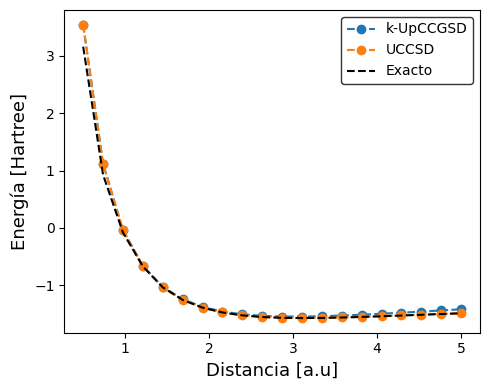

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5,4),)
ax.set_xlabel("Distancia [a.u]", fontsize=13)
ax.set_ylabel("Energía [Hartree]", fontsize=13)

ax.plot(np.linspace(0.5, 5, 20), potencial_k_hydrogen, marker='o', ls="dashed", label="k-UpCCGSD")
ax.plot(np.linspace(0.5, 5, 20), potencial_uc_hydrogen, marker='o', ls="dashed", label="UCCSD")
ax.plot(np.linspace(0.5, 5, 20), ee_final, color="black", ls="dashed", label="Exacto")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()